In [267]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
import math
import csv
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors

In [104]:
images_path = "/home/bmazoyer/Documents/Data/police/medias_unique/"

In [226]:
sample_size = 9000

In [227]:
def model_picker(name):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max')
    elif (name == 'mobilenet'):
        from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
        model = MobileNet(weights='imagenet',
                          include_top=False,
                          input_shape=(224, 224, 3),
                          pooling='max',
                          depth_multiplier=1,
                          alpha=1)
    elif (name == 'inception'):
        from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
        model = InceptionV3(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3),
                            pooling='max')
    elif (name == 'resnet'):
        from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
        model = ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                        pooling='max')
    elif (name == 'xception'):
        model = Xception(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='max')
    else:
        print("Specified model not available")
    return model

In [228]:
model_architecture = 'inception'
model = model_picker(model_architecture)

In [229]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [251]:
import random
random_image = random.choice(list(os.listdir(images_path)))

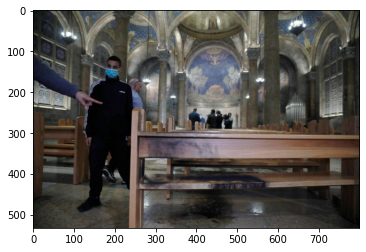

In [252]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(images_path + random_image))

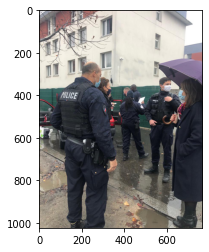

In [238]:
police_image = "1334445895925047298_EoUxCgAXMAE9egv.jpg"
plt.imshow(mpimg.imread(images_path + police_image))

In [253]:
features = extract_features(images_path + random_image, model)
print(len(features))

2048


In [254]:
%timeit features = extract_features(images_path + random_image, model)

74 ms ± 3.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [255]:
filenames = [images_path + f for f in os.listdir(images_path)]
filenames = random.sample(filenames, sample_size)

In [259]:
police_index = filenames.index(images_path + police_image)

In [256]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

<ipython-input-256-21d73bc1ed80>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


/home/bmazoyer/.pyenv/versions/3.8.2/envs/image/lib/python3.8/site-packages/PIL/Image.py:988: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Save features and associated filenames to disk

### Load features and associated filenames from disk

In [324]:
n_neighbors = 4

In [325]:
neighbors = NearestNeighbors(n_neighbors=n_neighbors,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)

In [328]:
# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = n_neighbors
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + filenames[i].replace(images_path, ""))
        else:
            ax.set_title("Similar Image\n" + filenames[i].replace(images_path, "") +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
    #plt.savefig(filenames[0].replace(images_path, "") + 'nearest_neighbors.pdf', format='pdf', dpi=1000)
    # We will use this line repeatedly in our code.

<ipython-input-328-77ecd347b972>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / columns + 1, columns, i + 1)


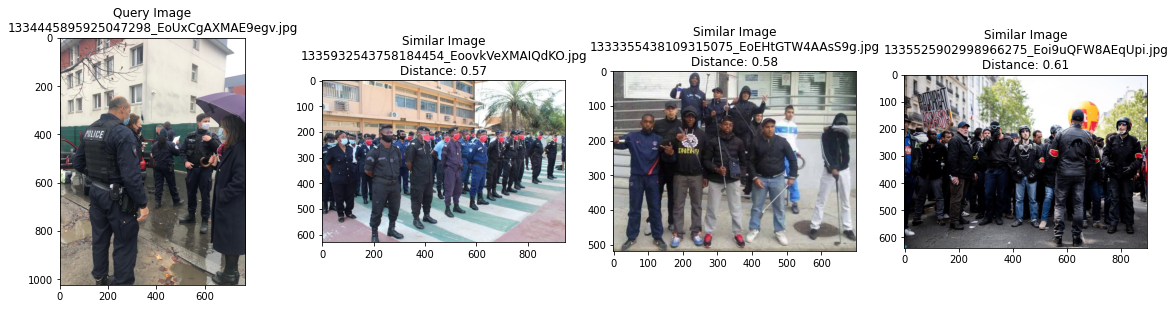

In [329]:
distances, indices = neighbors.kneighbors([feature_list[police_index]])
# Don't take the first closest image as it will be the same image
similar_image_paths = [filenames[police_index]] + [filenames[indices[0][i]] for i in range(1, n_neighbors)]
plot_images(similar_image_paths, distances[0])

In [221]:
from sklearn.manifold import TSNE

# You can play with these values and see how the results change
n_components = 2
verbose = 1
perplexity = 50
n_iter = 50000
metric = 'cosine'

time_start = time.time()
tsne_results = TSNE(n_components=n_components,
                    verbose=verbose,
                    perplexity=perplexity,
                    n_iter=n_iter,
                    metric=metric).fit_transform(np.array(feature_list))

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))



[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.126488
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.740417
[t-SNE] KL divergence after 2100 iterations: 1.324348
t-SNE done! Time elapsed: 7.146559953689575 seconds


In [222]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from PIL import Image

def plot_images_in_2d(x, y, image_paths, axis=None, zoom=1):
    if axis is None:
        axis = plt.gca()
    x, y = np.atleast_1d(x, y)
    for x0, y0, image_path in zip(x, y, image_paths):
        image = Image.open(image_path)
        image.thumbnail((100, 100), Image.ANTIALIAS)
        img = OffsetImage(image, zoom=zoom)
        anno_box = AnnotationBbox(img, (x0, y0),
                                  xycoords='data',
                                  frameon=False)
        axis.add_artist(anno_box)
    axis.update_datalim(np.column_stack([x, y]))
    axis.autoscale()



In [223]:
def show_tsne(x, y, selected_filenames, suffix):
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
    plt.savefig("{}_police_images_{}.png".format(sample_size, suffix))



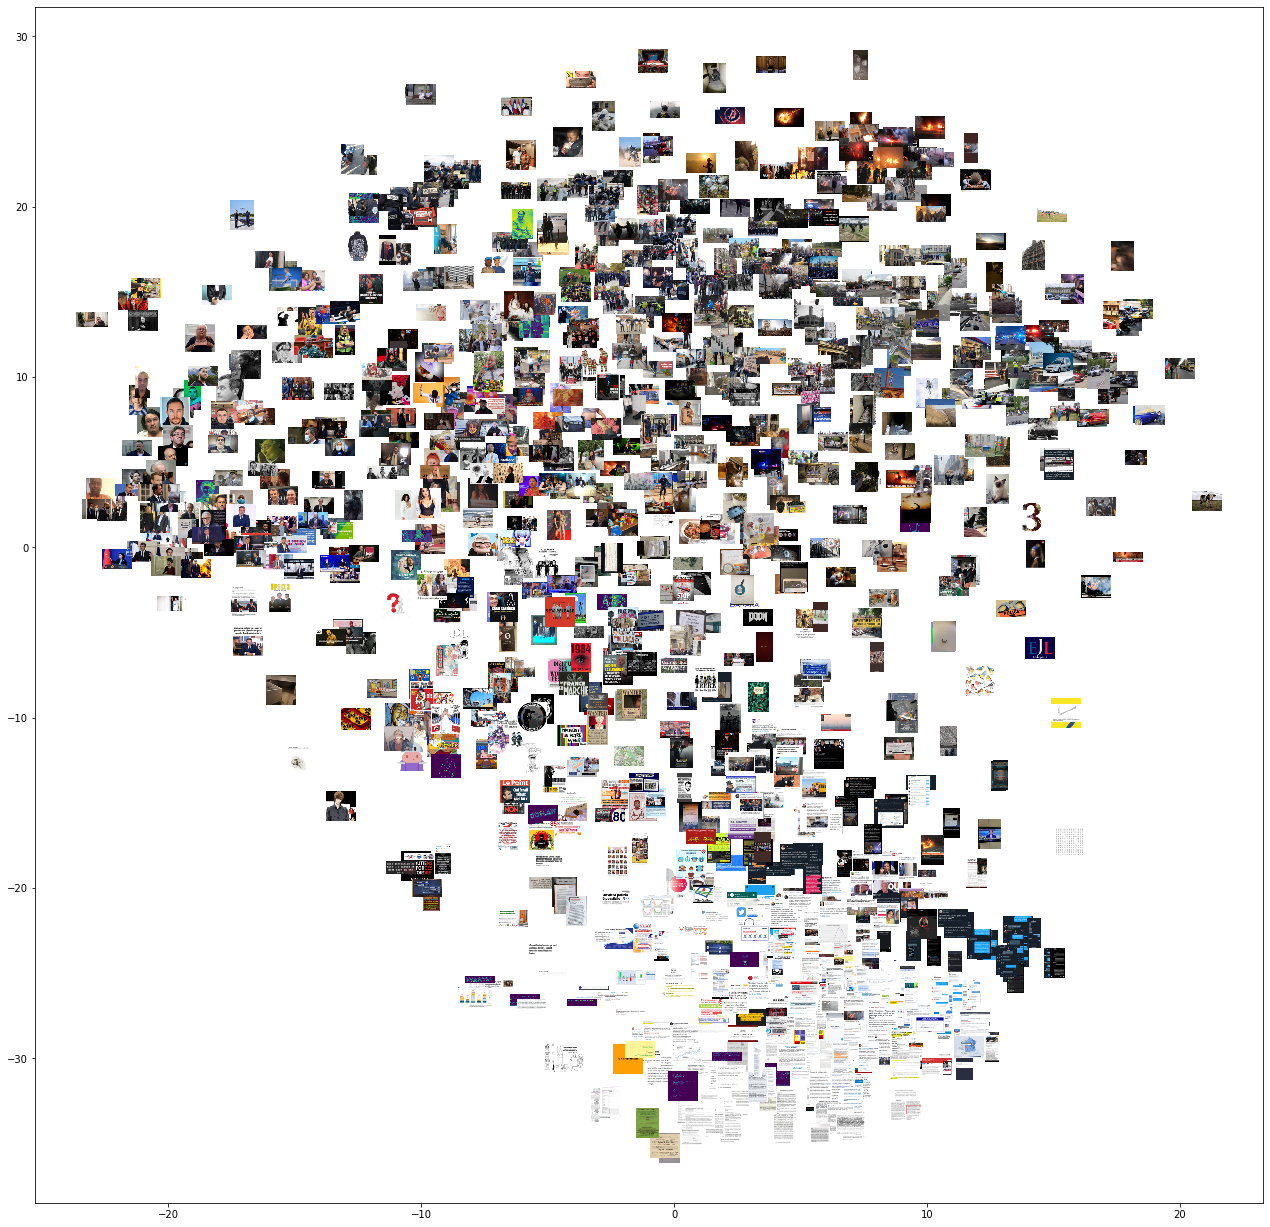

In [224]:
show_tsne(tsne_results[:, 0], tsne_results[:, 1], filenames, model_architecture)

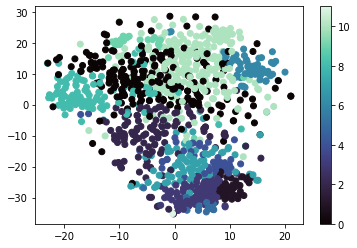

In [225]:
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns

db = MiniBatchKMeans(n_clusters=12).fit(feature_list)
labels = db.labels_
color_map = sns.color_palette("mako", as_cmap=True)
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

In [178]:
def tsne_to_grid_plotter_manual(x, y, selected_filenames):
    S = 2000
    s = 100
    x = (x - min(x)) / (max(x) - min(x))
    y = (y - min(y)) / (max(y) - min(y))
    x_values = []
    y_values = []
    filename_plot = []
    x_y_dict = {}
    for i, image_path in enumerate(selected_filenames):
        a = np.ceil(x[i] * (S - s))
        b = np.ceil(y[i] * (S - s))
        a = int(a - np.mod(a, s))
        b = int(b - np.mod(b, s))
        if str(a) + "|" + str(b) in x_y_dict:
            continue
        x_y_dict[str(a) + "|" + str(b)] = 1
        x_values.append(a)
        y_values.append(b)
        filename_plot.append(image_path)
    fig, axis = plt.subplots()
    fig.set_size_inches(22, 22, forward=True)
    plot_images_in_2d(x_values, y_values, filename_plot, zoom=.58, axis=axis)
    plt.show()



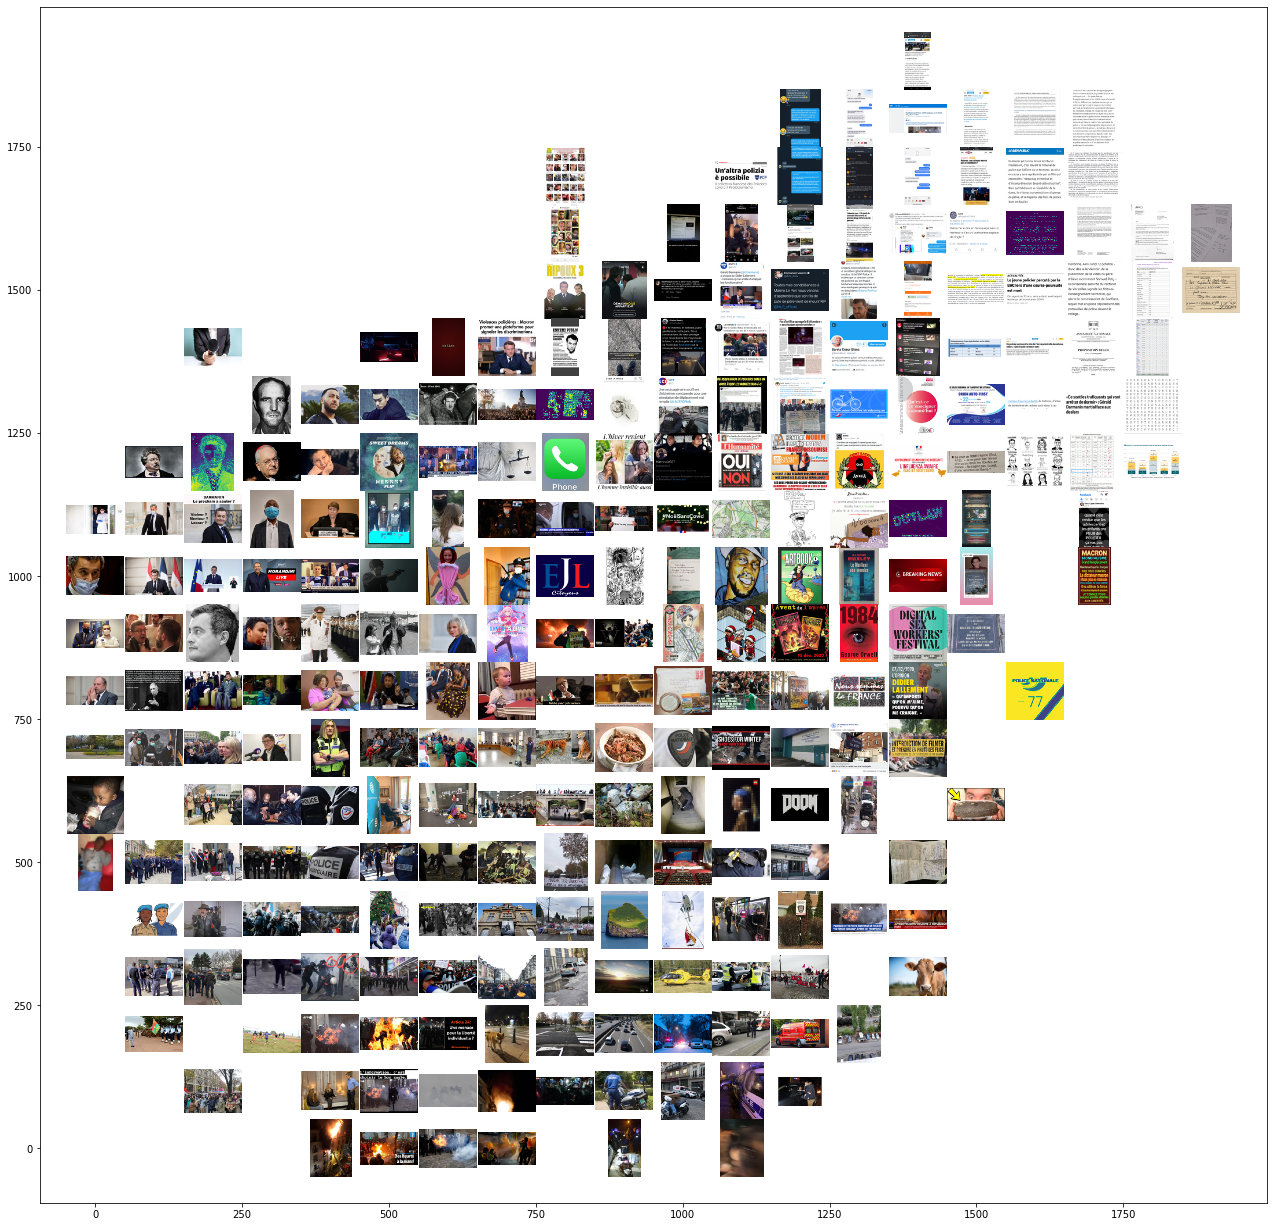

In [179]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            filenames)


In [180]:
from sklearn.decomposition import PCA

In [181]:
num_feature_dimensions = 100
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.155540
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.351593
[t-SNE] KL divergence after 1000 iterations: 1.440494
t-SNE done! Time elapsed: 3.3528032302856445 seconds


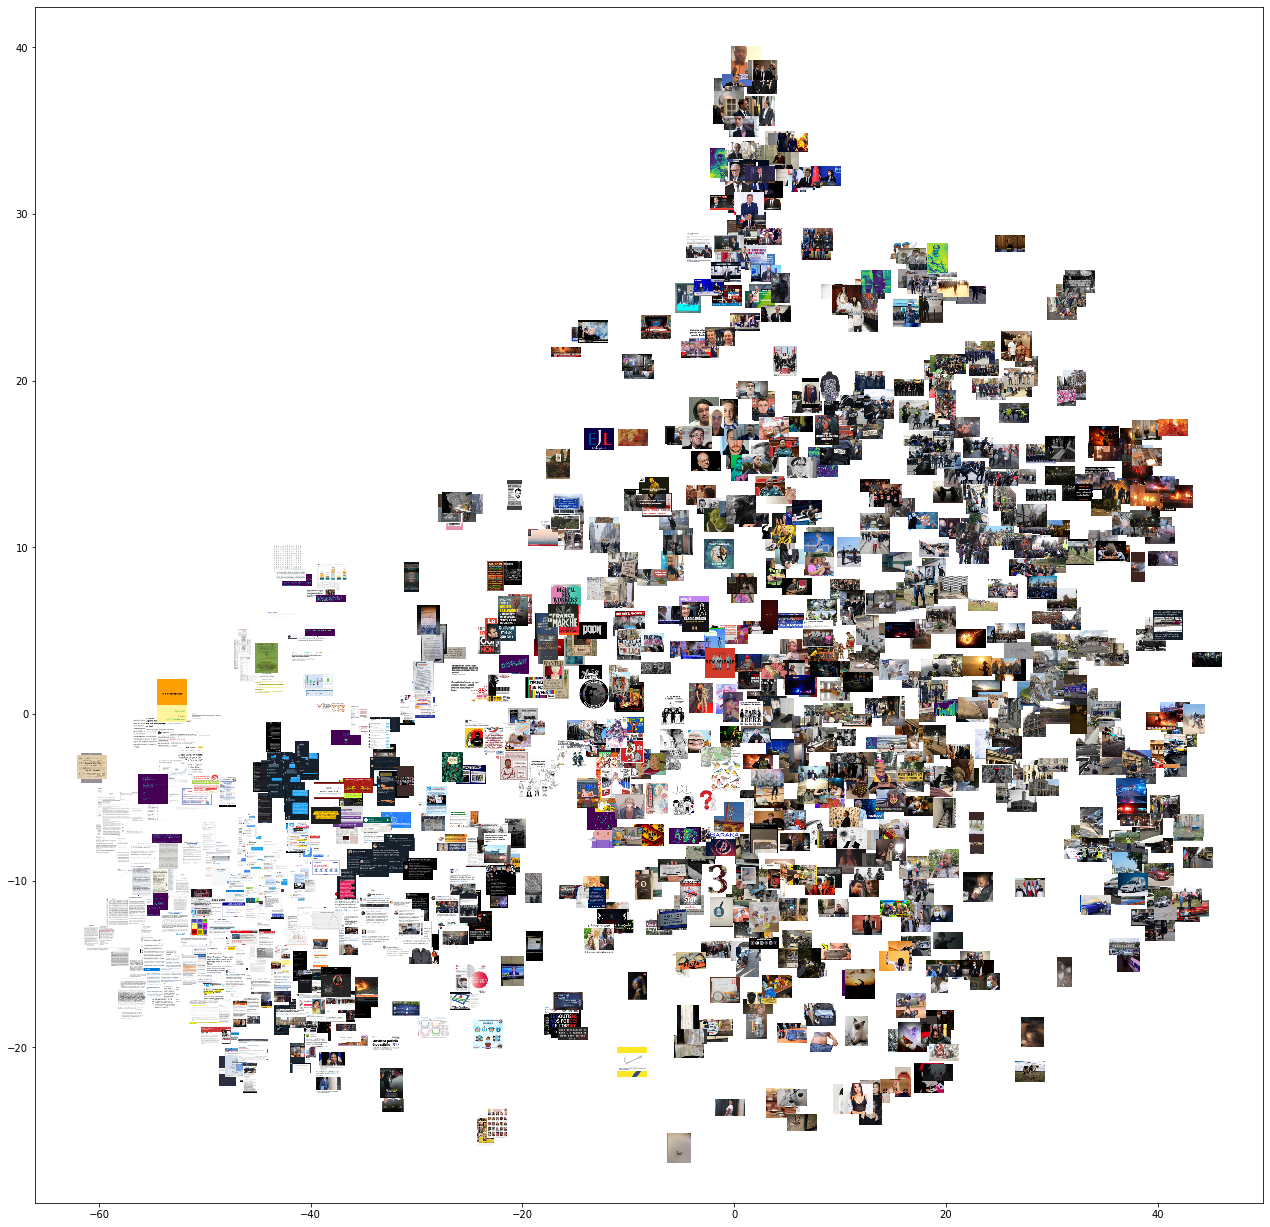

In [182]:
time_start = time.time()
tsne_results = TSNE(n_components=2, verbose=1,
                    metric='euclidean').fit_transform(feature_list_compressed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))


show_tsne(tsne_results[:, 0], tsne_results[:, 1], filenames, model_architecture + "_PCA")

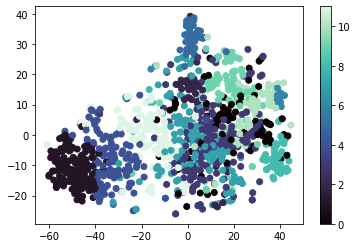

In [219]:
db = MiniBatchKMeans(n_clusters=12).fit(feature_list_compressed)
labels = db.labels_
color_map = sns.color_palette("mako", as_cmap=True)
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

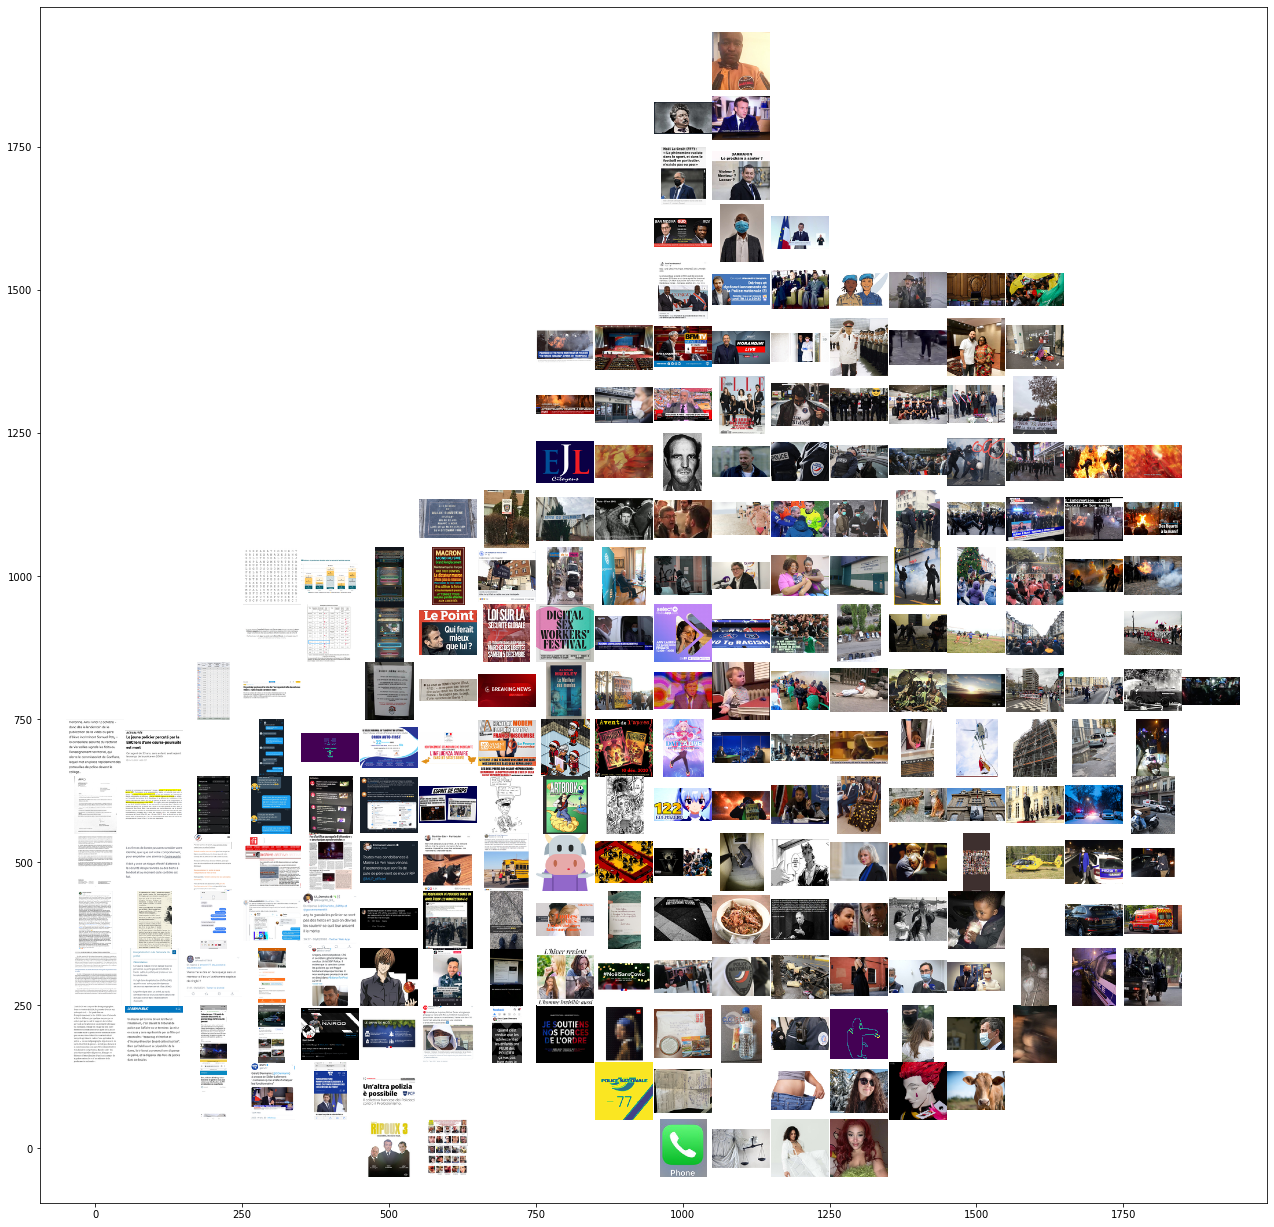

In [183]:
tsne_to_grid_plotter_manual(tsne_results[:, 0], tsne_results[:, 1],
                            filenames)

# Pour aller plus loin:

- faire un premier tri sur les tweets : ne garder que ceux effectivement captés avec les mots-clefs (pas quotes ou threads)
- tester umap
- regarder les k plus proches voisins d'une image de policier - Done
- voir où se trouve notre image de policier et ses voisins avec différents algos de clustering
- utiliser les snapshots de gifs comme base d'entraînement de détection de mêmes. À l'inverse, regarder les snapshots de vidéos et voir si ça peut servir de vérité de terrain de "photographies" (images réelles). Dans l'idéal, on veut filtrer les mêmes et garder les images réelles.